#### This demo is a brief overview of the documentation https://jetbrains.github.io/lets-plot-docs/pages/features/geocoding.html

The geodata is provided by © OpenStreetMap contributors and is made available here under the Open Database License (ODbL).



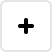
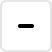
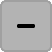
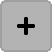
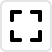
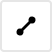
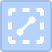

In [1]:
import shapely
from IPython.display import display, Markdown

from lets_plot import *
from lets_plot.geo_data import *

LetsPlot.setup_html()

In [2]:
def run_catching(f):
    def colored(s):
        return Markdown('<span style="color: #ff0000">{}</span>'.format(s))
    try:
        f()
        assert False, 'Error expected'
    except Exception as e:
        display(colored('{}'.format(e)))

### Basic usage

In [3]:
# Level autodetection
geocode(names=['florida', 'tx']).get_geocodes()

# Result may contain the following columns:
# id - for internal use. Only in geocodes DataFrame.
# request - column with lowest administrative level. The request belongs to this level. Can be a city/county/state/country.
# parents - if provided. Can be a county/state/country.
# found name - name that found by geocoding.
# geometry - only in geometry DataFrame.

# Thanks to request column it's obvious that level was detected as state.

id    state found name
0  324101  florida    Florida
1  229381       tx      Texas

In [4]:
# Explicit level
geocode_states(['florida', 'tx']).get_geocodes()

id    state found name
0  324101  florida    Florida
1  229381       tx      Texas

In [5]:
# Parameters can be change between searches
florida = geocode_states('florida')

display(florida.countries('usa').get_geocodes())
display(florida.countries('uruguay').get_geocodes())
display(florida.countries(None).get_geocodes())

id    state found name country
0  324101  florida    Florida     usa

id    state found name  country
0  3270329  florida    Florida  uruguay

id    state found name
0  324101  florida    Florida

### Scope

In [6]:
# str scope uses level autodetection.
# NB: Florida in USA is the most relevant result.
#     We can't find Florida in Uruguay using only the name - parent (country or scope) is required.
geocode_states('florida').scope('uruguay').get_geocodes()

id    state found name
0  3270329  florida    Florida

In [7]:
# Geocoder scope
uruguay = geocode_countries('uruguay')
geocode_states('florida').scope(uruguay).get_geocodes()

id    state found name
0  3270329  florida    Florida

In [8]:
# Scope is a singleton. Collections are not allowed.
scope = ['uruguay']
run_catching(
    lambda: geocode_states('florida').scope(scope).get_geocodes()
)

<span style="color: #ff0000">Unsupported 'scope' type. Expected 'str' or 'Geocoder' but was 'list'</span>

In [9]:
# Geocoder with more than one entry is not allowed too.
scope = geocode_countries(['uruguay', 'usa'])
run_catching(
    lambda: geocode_states('florida').scope(scope).get_geocodes()
)

<span style="color: #ff0000">'scope' has 2 entries, but expected to have exactly 1</span>

In [10]:
# str scope can be ambiguous.
run_catching(
    lambda: geocode_cities('worcester').scope('worcester county').get_geocodes()
)

# Let's geocode Worcester County in a way how the service does - using level detection without parents.
# In fact Worcester County was found, but error message in case of parent ambiguity is not clear. We will improve it.
run_catching(
    lambda: geocode_counties('worcester county').get_geocodes()
)

<span style="color: #ff0000">Region is not found: worcester county</span>

<span style="color: #ff0000">Multiple objects (2) were found for worcester county:
- Worcester County (United States, Maryland)
- Worcester County (United States, Massachusetts)
</span>

### Parents.

In [11]:
# Parents should have same length as names
geocode_cities(['warwick', 'worcester'])\
    .counties(['Worth County', 'worcester county'])\
    .states(['georgia', 'massachusetts'])\
    .get_geocodes()

id       city found name            county          state
0   239553    warwick    Warwick      Worth County        georgia
1  3688419  worcester  Worcester  worcester county  massachusetts

In [12]:
# Parents can contain None items (e.g., countries with different administrative divisions).
geocode_cities(['warwick', 'worcester'])\
    .states(['Georgia', None])\
    .countries(['USA', 'United Kingdom'])\
    .get_geocodes()

id       city found name    state         country
0   239553    warwick    Warwick  Georgia             USA
1  3750683  worcester  Worcester     None  United Kingdom

In [13]:
# Geocoder object can be used as parent. Number of entries should be same as the number of names.
s = geocode_states(['vermont', 'georgia']).scope('usa')
display(s.get_geocodes())

# NB: Parent request will be present in result as a column.
display(geocode_cities(['worcester', 'warwick']).states(s).get_geocodes())

id    state found name
0  121519  vermont    Vermont
1  323915  georgia    Georgia

id       city found name    state
0  17796275  worcester  Worcester  vermont
1    239553    warwick    Warwick  georgia

In [14]:
# counties and states can be combined with scope. scope acts as a top level parent.
geocode_counties(['Dakota County', 'Nevada County']).states(['NE', 'AR']).scope('USA').get_geocodes()

id         county     found name state
0  2850895  Dakota County  Dakota County    NE
1  3653651  Nevada County  Nevada County    AR

In [15]:
# scope can't be combined with countries - geocoding won't try to guess what level is it
run_catching(
    lambda: geocode_counties('Nevada County').countries('usa').scope('Arizona').get_geocodes()
)

<span style="color: #ff0000">Invalid request: countries and scope can't be used simultaneously</span>

In [16]:
# Parents and names should have same length
run_catching(
    lambda: geocode_states(['florida', 'rivera']).countries('uruguay').get_geocodes()
)

<span style="color: #ff0000">Invalid request: countries count(1) != names count(2)</span>

In [17]:
# Same for Geocoder
countries = geocode_countries('uruguay')
run_catching(
    lambda: geocode_states(['florida', 'rivera']).countries(countries).get_geocodes()
)

<span style="color: #ff0000">Invalid request: countries count(1) != names count(2)</span>

### Ignoring an ambiguity

In [18]:
# Ambiguous result generates an error:
run_catching(
    lambda: geocode_cities(['warwick', 'worcester']).get_geocodes()
)

<span style="color: #ff0000">Multiple objects (14) were found for warwick:
- Warwick (United States, Georgia, Worth County)
- Warwick (United States, New York, Orange County)
- Warwick (United Kingdom, England, West Midlands, Warwickshire)
- Warwick (United States, North Dakota, Benson County)
- Warwick (United States, Oklahoma, Lincoln County)
- Warwick (United States, Rhode Island, Kent County)
- Warwick (United States, Massachusetts, Franklin County)
- Warwick (Canada, Ontario, Southwestern Ontario, Lambton County)
- Warwick (Canada, Québec, Centre-du-Québec, Arthabaska)
- West Warwick (United States, Rhode Island, Kent County)
Multiple objects (4) were found for worcester:
- Worcester (United States, Massachusetts, Worcester County)
- Worcester (United Kingdom, England, West Midlands, Worcestershire)
- Worcester (United States, Vermont, Washington County)
- Worcester Township (United States, Pennsylvania, Montgomery County)
</span>

In [19]:
# Ambiguous result can be converted to a matching result (e.g., for drawing on a map)
geocode_cities(['warwick', 'worcester']).allow_ambiguous().get_geocodes()

id       city                   found name
0     239553    warwick                      Warwick
1     352173    warwick                      Warwick
2     352897    warwick                      Warwick
3     363189    warwick                      Warwick
4     368499    warwick                      Warwick
5     785807    warwick                      Warwick
6    3679247    warwick                      Warwick
7    8144841    warwick                      Warwick
8   15994531    warwick                      Warwick
9     382429    warwick                 West Warwick
10   6098747    warwick             Warwick Township
11   7042961    warwick             Warwick Township
12  18489127    warwick             Warwick Mountain
13  15994533    warwick  Sainte-Élizabeth-de-Warwick
14   3688419  worcester                    Worcester
15   3750683  worcester                    Worcester
16  17796275  worcester                    Worcester
17   6152583  worcester           Worcester Township

In [20]:
# Missing name gives an error
run_catching(
    lambda: geocode_cities(names=['paris', 'worcester', 'foo']).get_geocodes()
)

# Missing parent also gives an error
run_catching(
    lambda: geocode_cities('paris').countries('foo').get_geocodes()
)

<span style="color: #ff0000">No objects were found for foo.
</span>

<span style="color: #ff0000">Region is not found: foo</span>

In [21]:
# ignore_not_found() - ingore unknown names, keep everything else, including ambiguous names
run_catching(
    lambda: geocode_cities(['paris', 'worcester', 'foo']).ignore_not_found().get_geocodes()
)

# Missing parent also gives an error
run_catching(
    lambda: geocode_cities(['paris', 'worcester']).countries(['foo', None]).ignore_not_found().get_geocodes()
)

<span style="color: #ff0000">Multiple objects (4) were found for worcester:
- Worcester (United States, Massachusetts, Worcester County)
- Worcester (United Kingdom, England, West Midlands, Worcestershire)
- Worcester (United States, Vermont, Washington County)
- Worcester Township (United States, Pennsylvania, Montgomery County)
</span>

<span style="color: #ff0000">Multiple objects (4) were found for worcester:
- Worcester (United States, Massachusetts, Worcester County)
- Worcester (United Kingdom, England, West Midlands, Worcestershire)
- Worcester (United States, Vermont, Washington County)
- Worcester Township (United States, Pennsylvania, Montgomery County)
</span>

In [22]:
# ignore_all_errors() - keep only exactly matched names
geocode_cities(['paris', 'worcester', 'foo']).ignore_all_errors().get_geocodes()

geocode_cities(['paris', 'worcester']).countries(['france', 'foo']).ignore_all_errors().get_geocodes()

id   city found name country
0  14889  paris      Paris  france

In [23]:
# ignore_not_found() + allow_ambiguous() - see all ambiguous names without "not found" error
geocode_cities(['paris', 'worcester', 'foo']).ignore_not_found().allow_ambiguous().get_geocodes()

id       city          found name
0     14889      paris               Paris
1   3688419  worcester           Worcester
2   3750683  worcester           Worcester
3  17796275  worcester           Worcester
4   6152583  worcester  Worcester Township

In [24]:
# List only 10 first distinct not found names
run_catching(
    lambda: geocode_cities(['foo', 'foo', 'foo', 'foo4', 'foo5', 'foo6', 'foo7', 'foo8', 'foo9', 'foo10', 'foo11', 'foo12', 'foo13', 'foo14', 'foo15']).get_geocodes()
)

<span style="color: #ff0000">No objects were found for foo, foo4, foo5, foo6, foo7, foo8, foo9, foo10, foo11, foo12 and (3) more.
</span>

In [25]:
# Empty DataFrame if no matching names left
geocode_cities('worcester').ignore_all_errors().get_geocodes()

Empty DataFrame
Columns: [id, city, found name]
Index: []

### `where()` function

In [26]:
# Take object closest to a place.
boston = geocode_cities('boston')
geocode_cities('worcester').where('worcester', closest_to=boston).get_geocodes()

id       city found name
0  3688419  worcester  Worcester

In [27]:
# Take object closest to a coordinate.
boston_coord = boston.get_centroids().geometry[0]
geocode_cities('worcester').where('worcester', closest_to=boston_coord).get_geocodes()

id       city found name
0  3688419  worcester  Worcester

In [28]:
# Or take object within rectangular area
geocode_cities('worcester')\
    .where('worcester', scope=shapely.geometry.box(-71.00, 42.00, -72.00, 43.00))\
    .get_geocodes()

id       city found name
0  3688419  worcester  Worcester

In [29]:
# Or by defining a query scope. In this case name from the scope will not go into the result DataFrame
massachusetts = geocode_states('massachusetts')
geocode_cities('worcester').where('worcester', scope=massachusetts).get_geocodes()

id       city found name
0  3688419  worcester  Worcester

In [30]:
# Query scope also can be a string
geocode_cities('worcester').where('worcester', scope='massachusetts').get_geocodes()

id       city found name
0  3688419  worcester  Worcester

In [31]:
# Query scope overrides parents while keeping parents in a result dataframe.
worcester_county=geocode_counties('Worcester County').states('massachusetts').countries('usa')

geocode_cities(['worcester', 'worcester'])\
    .countries(['USA', 'United Kingdom'])\
    .where('worcester', country='USA', scope=worcester_county)\
    .get_geocodes()

id       city found name         country
0  3688419  worcester  Worcester             USA
1  3750683  worcester  Worcester  United Kingdom

In [32]:
# Query scope should contain single object
countries = geocode_countries(['usa', 'uruguay'])
run_catching(
    lambda: geocode_states('florida').where('florida', scope=countries).get_geocodes()
)

<span style="color: #ff0000">'scope' has 2 entries, but expected to have exactly 1</span>

In [33]:
# NB: Parent is used only for searching exact row in request. 
#     It doesn't modify any parent (neither existing or empty).
run_catching(
    lambda: geocode_cities('worcester')\
        .countries('USA')\
        .where('worcester', country='USA', state='iowa', county='worcester county')\
        .get_geocodes()
)

<span style="color: #ff0000">worcester(county=worcester county, state=iowa, country=USA) is not found in names</span>

In [34]:
geocode_cities('warwick') \
    .where('warwick', scope=shapely.geometry.box(-72, 41.5, -71, 42)) \
    .allow_ambiguous() \
    .get_geocodes()

id     city    found name
0  785807  warwick       Warwick
1  382429  warwick  West Warwick

#### Error handling

In [35]:
# Failed to find parent
run_catching(
    lambda: geocode_states('florida').countries('foo').get_geocodes()
)

<span style="color: #ff0000">Region is not found: foo</span>

In [36]:
# ambiguous parent - Worcester County. Better message required.
run_catching(
    lambda : geocode_cities('worcester').counties('worcester county').scope('usa').get_geocodes()
)

<span style="color: #ff0000">Region is not found: worcester county</span>

In [37]:
# No us-48 at non-state level
run_catching(
    lambda: geocode_counties('us-48').get_geocodes()
)

<span style="color: #ff0000">Invalid level for request with us-48. Should be STATE, but was COUNTY.</span>

### Geocoding and geoms

In [38]:
cities = geocode_cities(['boston', 'new york'])
p = ggplot() + ggsize(300, 200)

In [39]:
# geocoder object can be used as map parameter to simply display a geometry
plots = GGBunch()
plots.add_plot(p + geom_map(map=cities, fill='gray') + ggtitle('geom_map()'), 0, 0)
plots.add_plot(p + geom_rect(map=cities, fill='gray') + ggtitle('geom_rect()'), 300, 0)
plots.add_plot(p + geom_point(map=cities) + ggtitle('geom_point()'), 600, 0)
plots

In [40]:
# GeoDataFrame also can be also as map parameter to display a geometry - syntax is the same as with Geocoder.
# It is usefull for optimisation - geocoder caches geocodes, but doesn't cache geometries.
centroids = cities.get_centroids()
bboxes = cities.get_limits()
boundaries = cities.get_boundaries()
p = ggplot() + ggsize(300, 200)
plots = GGBunch()
plots.add_plot(p + geom_map(map=cities.get_boundaries(), fill='gray') + ggtitle('geom_map()'), 0, 0)
plots.add_plot(p + geom_rect(map=cities.get_limits(), fill='gray') + ggtitle('geom_rect()'), 300, 0)
plots.add_plot(p + geom_point(map=cities.get_centroids()) + ggtitle('geom_point()'), 600, 0)
plots

### map and map_join

In [41]:
# map_join allows to join data and geometry.
# To make it more difficult demo data contains cities with same name (Worcester).
# Also there is a city and state with same name (New York). 
# All names are in lower case to distinct user input from geocoding result.
from pandas import *
d = pandas.DataFrame({
    'City_Name': ['boston', 'new york', 'worcester', 'worcester'],
    'State_Name': ['massachusetts', 'new york', 'vermont', 'massachusetts'],
    'mean': [523, 556, 600, 533]
})

geocoder = geocode_cities(d.City_Name).states(d.State_Name)
geocoder.get_geocodes()

id       city found name          state
0   4631409     boston     Boston  massachusetts
1    351811   new york   New York       new york
2  17796275  worcester  Worcester        vermont
3   3688419  worcester  Worcester  massachusetts

In [42]:
# Cache boundaries
background_states = geocode_states(['massachusetts', 'new york', 'vermont']).inc_res().get_boundaries()

def draw_plot(map, map_join):
    return ggplot() + \
        geom_map(map=background_states) + \
        geom_point(aes(size='mean', color='City_Name'), data=d, map=map, map_join=map_join) + \
        theme(axis_line='blank', axis_text='blank', axis_ticks='blank', axis_title='blank')

In [43]:
# Draw a GeoDataFrame with a data. 
# Names in GeoDataFrame from Geocoder are predefined: 'city', 'county', 'state', 'country'
# Order of levels in map_join should match:
draw_plot(map=geocoder.get_centroids(), map_join=[['City_Name', 'State_Name'], ['city', 'state']])

# Note that Worcesters have proper position and data, but color is the same color. 
# To make the color distinct a new column with combination of city and state names can be used.

In [44]:
# With Geocoder it is much easier to draw a data. 
# Map columns will be generated with following order: city, county, state, country. Not used levels will be ommited.
# Data columns should follow this order.
draw_plot(map=geocoder, map_join=['City_Name', 'State_Name'])

In [45]:
# Not following the order leads to an unexpected result: 
draw_plot(map=geocoder, map_join=['State_Name', 'City_Name'])

In [46]:
us48 = geocode_states('us-48').inc_res()
p = ggplot() + \
    theme(axis_line='blank', axis_text='blank', axis_ticks='blank', axis_title='blank', legend_position='none') + \
    ggsize(600, 300)

In [47]:
# Geocoder can be passed to a data parameter. In this case column 'found name' can be used for join and styling:
p + \
    geom_map(aes(fill='found name'), data=us48, map=us48, map_join='found name', tooltips=layer_tooltips().line('@{found name}'))


In [48]:
# With GeoDataFrame as data a plot spec is even more compact
p + \
    geom_map(aes(fill='found name'), data=us48.get_boundaries(), tooltips=layer_tooltips().line('@{found name}'))

In [81]:
# map_join works fine even when data and map rows doesn't match

# For the simplicity I'll re-use states from us-48. Names can be provided by user.
import random
random.seed(1)
area_of_interest = us48.get_geocodes().state.tolist()
length = 30
mean_by_state = {
    'State_Name': random.sample(area_of_interest, length),
    'Mean_Value': random.sample(range(0, 500), length)
}

p + geom_map(
    aes(fill='Mean_Value'), 
    data=mean_by_state, map=us48, 
    map_join='State_Name', 
    tooltips=layer_tooltips()
        .line('@{found name}')
        .line('mean:|@Mean_Value')
)

# Note the variable 'found name' that is used in tooltip. 
# Thanks to map_join this variable is available for tooltip processor.